> Minor topics in CNN -- 다중클래스 분류, fastai metric 사용

# 강의영상 

<https://youtube.com/playlist?list=PLQqh36zP38-wVdrvMFFtAcAM2QC7ZpnN3>

# imports 

In [3]:
import torch 
import torchvision
import numpy as np
from fastai.vision.all import * 

In [4]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

# CNN 다중클래스 분류

## 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야 한다면? 

***일반적인 개념*** 

- 손실함수: BCE loss $\to$ Cross Entropy loss 
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: sig $\to$ softmax 

***파이토치 한정*** 

- **y의형태: (n,) vector + int형 // (n,k) one-hot encoded vector + float형**
- 손실함수: torch.nn.BCEWithLogitsLoss,  $\to$ torch.nn.CrossEntropyLoss
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의 활성화가 포함) 

## 실습: 3개의 클래스를 구분 

In [5]:
path = untar_data(URLs.MNIST)

training set 

In [6]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

test set 

In [7]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

`(1)` dls 

In [8]:
len(X)

18623

In [9]:
ds1 = torch.utils.data.TensorDataset(X,y) 
ds2 = torch.utils.data.TensorDataset(XX,yy) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번 iter
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 

In [10]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)

In [11]:
net1(X).shape

torch.Size([18623, 2304])

In [33]:
net = torch.nn.Sequential(
    net1,
    torch.nn.Linear(2304,3) # 0,1,2 3개를 구분하는 문제이므로 out_features=3 
)
loss_fn = torch.nn.CrossEntropyLoss() 

In [38]:
lrnr = Learner(dls,net,loss_fn) 

`(3)` 학습

In [39]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,0.155762,0.045966,00:00
1,0.087853,0.093116,00:00
2,0.089215,0.033146,00:00
3,0.075707,0.039687,00:00
4,0.063615,0.031188,00:00
5,0.055850,0.029167,00:00
6,0.050883,0.028610,00:00
7,0.047144,0.028127,00:00
8,0.044129,0.027425,00:00
9,0.041849,0.026887,00:00


`(4)` 예측

In [41]:
lrnr.model.to("cpu")

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=2304, out_features=3, bias=True)
)

In [50]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy) 

,0,1,2,y
0,2.025615,-17.453382,-2.335629,0
1,2.531184,-9.890347,-3.949971,0
2,1.587324,-13.035635,-3.257438,0
3,2.749664,-9.918694,-6.867003,0
4,2.155442,-15.885134,-3.019295,0
...,...,...,...,...
3142,-9.030737,-8.673495,1.204605,2
3143,-3.569304,-10.748278,-0.645055,2
3144,-3.627095,-12.919289,1.046083,2
3145,-5.151307,-9.524368,0.068864,2


In [51]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==0')

,0,1,2,y
0,2.025615,-17.453382,-2.335629,0
1,2.531184,-9.890347,-3.949971,0
2,1.587324,-13.035635,-3.257438,0
3,2.749664,-9.918694,-6.867003,0
4,2.155442,-15.885134,-3.019295,0
...,...,...,...,...
975,4.450414,-19.329332,-5.451057,0
976,2.597144,-21.202513,-2.372313,0
977,3.089397,-15.486772,-3.171502,0
978,2.591355,-17.475590,-3.039083,0


- 대체적으로 첫번째 칼럼의 숫자들이 다른칼럼보다 크다. 

In [52]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==1')

,0,1,2,y
980,-7.629252,2.701625,-3.049654,1
981,-6.666027,2.027717,-4.440878,1
982,-7.120140,3.354897,-3.937105,1
983,-7.139010,2.058928,-2.954304,1
984,-6.999043,3.258377,-3.432081,1
...,...,...,...,...
2110,-7.406105,4.032059,-3.826451,1
2111,-6.172441,3.187883,-3.490717,1
2112,-7.035848,3.202726,-3.547020,1
2113,-7.149322,1.741414,-1.765136,1


- 대체적으로 두번째 칼럼의 숫자들이 다른칼럼보다 크다. 

In [53]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==2')

,0,1,2,y
2115,-7.452892,-7.137640,0.605079,2
2116,-5.262731,-7.798437,-1.708323,2
2117,-9.056837,-9.649239,1.557607,2
2118,-6.614496,-10.291727,1.293422,2
2119,-3.120885,-10.670292,-0.660188,2
...,...,...,...,...
3142,-9.030737,-8.673495,1.204605,2
3143,-3.569304,-10.748278,-0.645055,2
3144,-3.627095,-12.919289,1.046083,2
3145,-5.151307,-9.524368,0.068864,2


- 대체적으로 세번째 칼럼의 숫자들이 다른칼럼보다 크다. 

`-` 예측하는방법? 
- 칼럼0의 숫자가 크다 -> y=0일 확률이 큼
- 칼럼1의 숫자가 크다 -> y=1일 확률이 큼 
- 칼럼2의 숫자가 크다 -> y=2일 확률이 큼

## 공부: Softmax 

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각 observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가 있음. 

`-` torch.nn.Softmax() 손계산 

(예시1) -- 잘못계산 

In [56]:
sftmax = torch.nn.Softmax(dim=0)

In [57]:
_netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [58]:
sftmax(_netout) 

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시2) -- 이게 맞게 계산되는 것임 

In [59]:
sftmax = torch.nn.Softmax(dim=1)

In [60]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [62]:
sftmax(_netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시3) -- 차원을 명시안하면 맞게 계산해주고 경고 줌 

In [63]:
sftmax = torch.nn.Softmax()

In [64]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [65]:
sftmax(_netout)

/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시4) -- 진짜 손계산 

In [66]:
_netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [71]:
torch.exp(_netout)

tensor([[ 0.1353,  0.1353,  1.0000],
        [23.1039, 23.1039, 23.1039],
        [ 1.0000,  1.0000,  7.3891],
        [ 7.3891,  7.3891, 54.5981],
        [ 1.0000,  1.0000,  1.0000]])

In [72]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

(0.10648512513773022, 0.10648512513773022, 0.7870297497245397)

In [81]:
np.exp(_netout[1])/np.exp(_netout[1]).sum() # 두번째 obs 

tensor([0.3333, 0.3333, 0.3333])

In [82]:
np.apply_along_axis(lambda x: np.exp(x) / np.exp(x).sum(),1,_netout)

array([[0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334],
       [0.10650699, 0.10650699, 0.78698605],
       [0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

## 공부: CrossEntropyLoss

### `#` ***torch.nn.CrossEntropyLoss() 손계산: one-hot version***

In [83]:
loss_fn = torch.nn.CrossEntropyLoss()

In [84]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [90]:
_y_onehot = torch.tensor([[0,0,1],
                          [0,1,0],
                          [0,0,1],
                          [0,0,1],
                          [1,0,0]])*1.0
_y_onehot

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]])

In [91]:
sftmax = torch.nn.Softmax(dim=1) 
sftmax(_netout), _y_onehot

(tensor([[0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333],
         [0.1065, 0.1065, 0.7870],
         [0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]))

`-` 계산결과 

In [92]:
loss_fn(_netout,_y_onehot)

tensor(0.5832)

In [101]:
- torch.sum(torch.log(sftmax(_netout)) * _y_onehot)/5 

tensor(0.5832)

`-` 계산하는 방법도 중요한데 torch.nn.CrossEntropyLoss() 에는 softmax 활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 더 중요함. 

`-` 따라서 torch.nn.CrossEntropyLoss() 는 사실 torch.nn.CEWithSoftmaxLoss() 정도로 바꾸는 것이 더 말이 되는 것 같다. 

### `#` ***torch.nn.CrossEntropyLoss() 손계산: lenght $n$ vertor version***

In [102]:
_netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [108]:
_y = torch.tensor([2,1,2,2,0])

In [109]:
loss_fn(_netout,_y)

tensor(0.5832)

## 실습: $k=2$로 두면 이진분류도 가능

`-` download data 

In [119]:
path = untar_data(URLs.MNIST) 

training 

In [192]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

In [203]:
y_onehot = torch.nn.functional.one_hot(y).float()
#y_onehot = torch.tensor(list(map(lambda x: [1,0] if x==0 else [0,1],y))).float()

test

In [204]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

In [205]:
yy_onehot = torch.nn.functional.one_hot(yy).float()
#yy_onehot = torch.tensor(list(map(lambda x: [1,0] if x==0 else [0,1],yy))).float()

`(1)` dls 

In [206]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot) 
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번 iter
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 

In [207]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2)
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn) 

`(3)` 학습

In [214]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,0.018623,0.012110,00:00
1,0.017453,0.010544,00:00
2,0.016391,0.009324,00:00
3,0.015412,0.008343,00:00
4,0.014506,0.007542,00:00
5,0.013664,0.006874,00:00
6,0.012881,0.006318,00:00
7,0.012152,0.005849,00:00
8,0.011473,0.005448,00:00
9,0.010841,0.005103,00:00


`(4)` 예측 및 시각화 

In [216]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=2, bias=True)
)

Text(0.5, 0.98, 'Training Set')

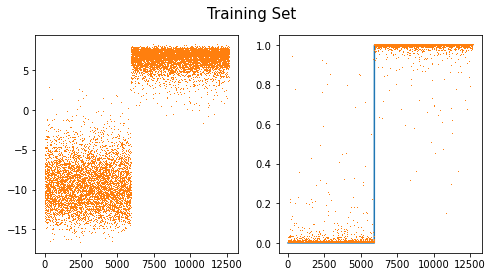

In [238]:
sftmax = torch.nn.Softmax(dim=1) 
sig = torch.nn.Sigmoid()
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).diff(axis=1).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(sftmax(net(X))[:,1].data,',')
#ax[1].plot(sig(net(X).diff(axis=1)).data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

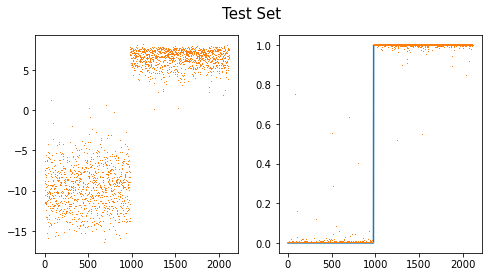

In [239]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).diff(axis=1).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(sftmax(net(XX))[:,1].data,',')
#ax[1].plot(sig(net(XX).diff(axis=1)).data,',')
fig.suptitle("Test Set",size=15)

`-` note: softmax(u1,u2)=[sig(u1-u2), sig(u2-u1)]=[1-sig(u2-u1),sig(u2-u1)]

## 공부: 이진분류에서 소프트맥스 vs 시그모이드 

`-` 이진분류문제 = "y=0 or y=1" 을 맞추는 문제 = 성공과 실패를 맞추는 문제 = 성공확률과 실패확률을 추정하는 문제 

`-` softmax, sigmoid

- softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는 실패확률과 성공확률을 둘다 추정한다. 
- sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만 추정한다. 

`-` 그런데 "실패확률=1-성공확률" 이므로 사실상 둘은 같은걸 추정하는 셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까) 

`-` 아래는 사실상 같은 모형이다. 

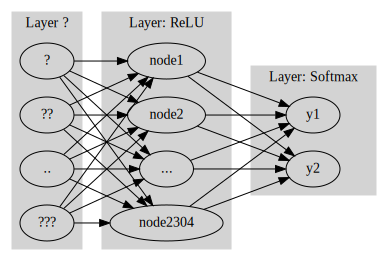

In [8]:
#|code-fold: true
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node2304" -> "y1"
    
    "node1" -> "y2"
    "node2" -> "y2"
    "..." -> "y2"
    "node2304" -> "y2"    
    label = "Layer: Softmax"
}
''')

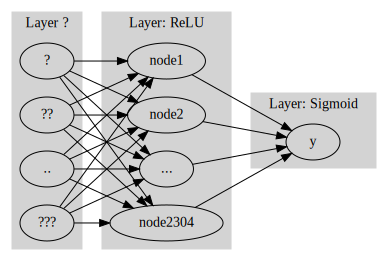

In [7]:
#|code-fold: true
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node2304" -> "y"
    label = "Layer: Sigmoid"
}
''')

`-` 둘은 사실상 같은 효과를 주는 모형인데 학습할 파라메터는 sigmoid의 경우가 더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는 동일하다는 말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함. 

- softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이 불가능한 반면 softmax는 확장이 용이하다는 장점이 있음 

## 소프트맥스 vs 시그모이드 정리 

`-` 결론 

1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를 칼라잉크로 출력하는 느낌) 

***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|None (or Identity)|MSE|
|0 or 1|이항분포 with $n=1$ (=베르누이) |Sigmoid| BCE|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포 with $n=1$|Softmax| Cross Entropy |

# fastai metric 사용 

## 데이터준비

`-` download data 

In [244]:
path = untar_data(URLs.MNIST)

`-` training set 

In [245]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [246]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [247]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

## 사용자정의 메트릭이용 

`(1)` dls 만들기

In [248]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성 

In [249]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 

In [257]:
def acc(yhat,y) : 
    return ((yhat>0.5)==y).float().mean()

In [258]:
def err(yhat,y):
    return 1-((yhat>0.5)==y).float().mean()

In [259]:
lrnr = Learner(dls,net,loss_fn,metrics=[acc,err])

`(3)` 학습

In [260]:
lrnr.fit(10)

epoch,train_loss,valid_loss,acc,err,time
0,0.930635,0.633062,0.463357,0.536643,00:00
1,0.700525,0.435254,0.989125,0.010875,00:00
2,0.562099,0.293302,0.992435,0.007565,00:00
3,0.453646,0.169834,0.992908,0.007092,00:00
4,0.360984,0.098153,0.994326,0.005674,00:00
5,0.286862,0.062732,0.993853,0.006147,00:00
6,0.229778,0.044261,0.994799,0.005201,00:00
7,0.185838,0.032975,0.995745,0.004255,00:00
8,0.151484,0.025062,0.996217,0.003783,00:00
9,0.124157,0.019350,0.996690,0.003310,00:00


`(4)` 예측

- 생략

## fastai지원 메트릭이용-- 잘못된사용 

`(1)` dls 만들기

In [263]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성 

In [264]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

In [265]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/anaconda3/envs/py37/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [266]:
error_rate??

Signature: error_rate(inp, targ, axis=-1)
Source:   
def error_rate(inp, targ, axis=-1):
    "1 - `accuracy`"
    return 1 - accuracy(inp, targ, axis=axis)
File:      ~/anaconda3/envs/py37/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


`(3)` 학습

In [267]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.958819,0.638672,0.463357,0.536643,00:00
1,0.698769,0.425380,0.463357,0.536643,00:00
2,0.556408,0.278437,0.463357,0.536643,00:00
3,0.447104,0.153257,0.463357,0.536643,00:00
4,0.352915,0.088516,0.463357,0.536643,00:00
5,0.278620,0.056958,0.463357,0.536643,00:00
6,0.221951,0.040489,0.463357,0.536643,00:00
7,0.178791,0.030974,0.463357,0.536643,00:00
8,0.145480,0.024886,0.463357,0.536643,00:00
9,0.119392,0.020659,0.463357,0.536643,00:00


- 이상하다..? 

`(4)` 예측 

In [268]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

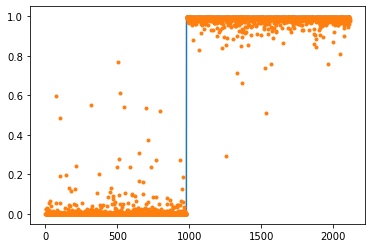

In [269]:
plt.plot(yy)
plt.plot(lrnr.model(XX).data,'.')

- 맞추는건 잘 맞추는데? 

## fastai지원 메트릭이용-- 올바른 사용(1)

`-` 가정

- X의 형태는 (n,채널,픽셀,픽셀)로 가정한다. 
- y의 형태는 (n,) 벡터이다. 즉 $n\times 1$ 이 아니라 그냥 길이가 $n$인 벡터로 가정한다. 
- y의 각 원소는 0,1,2,3,... 와 같이 카테고리를 의미하는 숫자이어야 하며 이 숫자는 int형으로 저장되어야 한다. 
- loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서 네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야 한다.)

`(1)` dls 만들기

In [273]:
y.to(torch.int64).reshape(-1),yy.to(torch.int64).reshape(-1)

(tensor([0, 0, 0,  ..., 1, 1, 1]), tensor([0, 0, 0,  ..., 1, 1, 1]))

In [275]:
ds1 = torch.utils.data.TensorDataset(X,y.to(torch.int64).reshape(-1))
ds2 = torch.utils.data.TensorDataset(XX,yy.to(torch.int64).reshape(-1))
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성 

In [277]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

`(3)` 학습

In [278]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.083689,0.592268,0.463357,0.536643,00:00
1,0.674220,0.340684,0.963593,0.036407,00:00
2,0.510727,0.152380,0.991489,0.008511,00:00
3,0.380071,0.069530,0.997163,0.002837,00:00
4,0.284898,0.038776,0.997163,0.002837,00:00
5,0.217856,0.025257,0.997163,0.002837,00:00
6,0.169902,0.018588,0.997163,0.002837,00:00
7,0.134621,0.014637,0.998582,0.001418,00:00
8,0.107967,0.012024,0.998582,0.001418,00:00
9,0.087427,0.010147,0.998582,0.001418,00:00


## fastai지원 메트릭이용-- 올바른 사용(2)

`-` 가정 

- X의 형태는 (n,채널,픽셀,픽셀)로 가정한다. 
- y의 형태는 (n,클래스의수)로 가정한다. 즉 y가 one_hot 인코딩된 형태로 가정한다. 
- y의 각 원소는 0 혹은 1이다. 
- loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서 네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야 한다.)

`(1)` dls 만들기

In [281]:
y_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], y)))
yy_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], yy)))
# y_onehot = torch.nn.functional.one_hot(y.reshape(-1).to(torch.int64)).to(torch.float32)
# yy_onehot = torch.nn.functional.one_hot(yy.reshape(-1).to(torch.int64)).to(torch.float32)

In [294]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot)
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성 

In [301]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy_multi])

`(3)` 학습

In [303]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.073728,0.608127,0.463357,00:00
1,0.683059,0.328684,0.982979,00:00
2,0.508058,0.156030,0.990780,00:00
3,0.378242,0.071232,0.995272,00:00
4,0.284064,0.041114,0.995981,00:00
5,0.217714,0.027780,0.996217,00:00
6,0.170183,0.021023,0.995981,00:00
7,0.135240,0.016962,0.996927,00:00
8,0.108881,0.014204,0.997400,00:00
9,0.088585,0.012181,0.997872,00:00
